In [1]:
#Load Libraries

import pandas as pd
import matplotlib.pyplot as plt
from pandas._libs.tslibs import timestamps
import seaborn as sns
import math
import ipywidgets as widgets
from ipywidgets import interact,interactive,fixed
from IPython.display import display
from seaborn import widgets
from ipyfilechooser import FileChooser
%matplotlib widget



In [2]:
#Define Functions

def read_file(path):
    return pd.read_csv(path , delimiter=";")

#Convert Data
def convert_data_type(data):
    
    data["Timestamp"] = pd.to_datetime(data["Timestamp"], unit = 's')
    
    if(data.dtypes["CognitiveLoadValue"] == object):
        data["CognitiveLoadValue"] = data["CognitiveLoadValue"].str.replace(',','.')
    
    if(data.dtypes["RightEyePupilPositionX"] == object):
        data["RightEyePupilPositionX"] = data["RightEyePupilPositionX"].str.replace(',','.')

    if(data.dtypes["RightEyePupilPositionY"] == object):
        data["RightEyePupilPositionY"] = data["RightEyePupilPositionY"].str.replace(',','.')

    if(data.dtypes["LeftEyePupilPositionX"] == object):
        data["LeftEyePupilPositionX"] = data["LeftEyePupilPositionX"].str.replace(',','.')

    if(data.dtypes["LeftEyePupilPositionY"] == object):
        data["LeftEyePupilPositionY"] = data["LeftEyePupilPositionY"].str.replace(',','.')

    if(data.dtypes["LeftEyePupilDilation"] == object):
        data["LeftEyePupilDilation"] = data["LeftEyePupilDilation"].str.replace(',','.')
        data["LeftEyePupilDilation"] = data["LeftEyePupilDilation"].replace({'-1':None})
        data["LeftEyePupilDilation"] = pd.to_numeric(data["LeftEyePupilDilation"], downcast='float')

    if(data.dtypes["RightEyePupilDilation"] == object):
        data["RightEyePupilDilation"] = data["RightEyePupilDilation"].str.replace(',','.')
        data["RightEyePupilDilation"] = data["RightEyePupilDilation"].replace({'-1':None})
        data["RightEyePupilDilation"] = pd.to_numeric(data["RightEyePupilDilation"], downcast='float')
        

    scene = ""
    if("Stabilization" in data):
        if("TaskAudio" in data):
            scene = "TripleTask"
        else:
            scene = "DoubleTask"
    else:
        scene = "Calcul"


    #DataFrame Triple Task
    if(scene == "TripleTask"):
        AudioStart = []
        AudioEnd = []
        AudioWrong = []
        AudioCorrect = []

        MathStart = []
        MathEnd = []
        MathWrong = []
        MathCorrect = []

        StabilizationWrong = []
        StabilizationCorrect = []

        for i in range(len(data.index)):
            if(data.loc[i, 'TaskAudio'] == 'Start'):
                AudioStart.append(i)

            if(data.loc[i, 'TaskAudio'] == 'End'):
                AudioEnd.append(i)

            if(data.loc[i, 'AnswerAudio'] == 'Correct'):
                AudioCorrect.append(i)

            if(data.loc[i, 'AnswerAudio'] == 'Wrong'):
                AudioWrong.append(i)

            if(data.loc[i, 'TaskMath'] == 'Start'):
                MathStart.append(i)

            if(data.loc[i, 'TaskMath'] == 'End'):
                MathEnd.append(i)

            if(data.loc[i, 'AnswerMath'] == 'Correct'):
                MathCorrect.append(i)

            if(data.loc[i, 'AnswerMath'] == 'Wrong'):
                MathWrong.append(i)

            if(data.loc[i, 'Stabilization'] == 'Wrong Direction'):
                StabilizationWrong.append(i)

            if(data.loc[i, 'Stabilization'] == 'Correct Direction'):
                StabilizationCorrect.append(i)

            
        
        dataDict = dict();
        dataDict['data'] = data
        dataDict['AudioStart'] = AudioStart
        dataDict['AudioEnd'] = AudioEnd
        dataDict['AudioCorrect'] = AudioCorrect
        dataDict['AudioWrong'] = AudioWrong

        dataDict['MathStart'] = MathStart
        dataDict['MathEnd'] = MathEnd
        dataDict['MathCorrect'] = MathCorrect
        dataDict['MathWrong'] = MathWrong

        dataDict['StabilizationCorrect'] = StabilizationCorrect
        dataDict['StabilizationWrong'] = StabilizationWrong
    #DataFrame Double Task
    elif(scene == "DoubleTask"):
        MathWrong = []
        MathCorrect = []
        StabilizationWrong = []
        StabilizationCorrect = []
        for i in range(len(data.index)):
            if(data.loc[i, 'AnswerMath'] == 'Correct'):
                    MathCorrect.append(i)

            if(data.loc[i, 'AnswerMath'] == 'Wrong'):
                MathWrong.append(i)

            if(data.loc[i, 'Stabilization'] == 'Wrong'):
                StabilizationWrong.append(i)

            if(data.loc[i, 'Stabilization'] == 'Correct'):
                StabilizationCorrect.append(i)
                
        dataDict = dict();
        dataDict['data'] = data
        dataDict['MathCorrect'] = MathCorrect
        dataDict['MathWrong'] = MathWrong
        dataDict['StabilizationCorrect'] = StabilizationCorrect
        dataDict['StabilizationWrong'] = StabilizationWrong
    #DataFrame Calcul
    else:
        MathWrong = []
        MathCorrect = []

        for i in range(len(data.index)):
            if(data.loc[i, 'AnswerMath'] == 'Correct'):
                    MathCorrect.append(i)

            if(data.loc[i, 'AnswerMath'] == 'Wrong'):
                MathWrong.append(i)
                
        dataDict = dict();
        dataDict['data'] = data
        dataDict['MathCorrect'] = MathCorrect
        dataDict['MathWrong'] = MathWrong

    return dataDict

#Make the Pupil Distance Calcul
def calculate_distance(xa,ya, xb, yb):
    if(xa == -1 or ya == -1 or xb == -1 or yb == -1):
        return None
    return math.sqrt(math.pow((xb - xa),2) + math.pow((yb - ya),2))

#Fill Pupil Distance Fields
def pupil_distance(data):

    data['RightEyePupilDistance'] = 0
    data['LeftEyePupilDistance'] = 0
    
    for i in range(len(data.index)):
        if(i != 0):
            data.loc[i,'RightEyePupilDistance'] = calculate_distance(float(data.loc[i,'RightEyePupilPositionX']),float(data.loc[i,'RightEyePupilPositionY']),float(data.loc[i-1,'RightEyePupilPositionX']),float(data.loc[i-1,'RightEyePupilPositionY']))   
            data.loc[i,'LeftEyePupilDistance'] = calculate_distance(float(data.loc[i,'LeftEyePupilPositionX']),float(data.loc[i,'LeftEyePupilPositionY']),float(data.loc[i-1,'LeftEyePupilPositionX']),float(data.loc[i-1,'LeftEyePupilPositionY']))   
    return data

#Plotting Heart Rate x Time
def plot_heart_rate(dataDict):
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)

    data = dataDict['data']
    plt.plot(data["Timestamp"],data["HeartRate"]) 
    plt.xlabel("Time")
    plt.ylabel("HeartRate")
    plt.title("Heart Rate x Time")
    plt.show()

#Plotting Heart Rate x Cognitive Load
def plot_hr_cl(dataDict):
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)
    
    data = dataDict['data']
    fig, hr = plt.subplots()
    fig.subplots_adjust(right=0.75)
    cl = hr.twinx()
    
    p1, = hr.plot(data["Timestamp"],data["HeartRate"],"tab:blue",label='Heart Rate') 
    p2, = cl.plot(data["Timestamp"],data["CognitiveLoadValue"],"tab:red", label= 'Cognitive Load')
    
    hr.set_xlabel("Time")
    hr.set_ylabel("Heart Rate")
    cl.set_ylabel("Cognitive Load")
    hr.yaxis.label.set_color(p1.get_color())
    cl.yaxis.label.set_color(p2.get_color())
    
    tkw = dict(size=4, width=1.5)
    hr.tick_params(axis='y', colors=p1.get_color(), **tkw)
    cl.tick_params(axis='y', colors=p2.get_color(), **tkw)
    hr.tick_params(axis='x', **tkw)
    hr.legend(handles=[p1, p2])
    plt.title("Heart Rate x Cognitive Load")
    plt.show() 

#Plotting Pupil Dilation x Time
def plot_pupil_dilation(dataDict):
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)

    data = dataDict['data']
    plt.plot(data["Timestamp"],data["RightEyePupilDilation"],"tab:blue",label='Right Eye Pupil Dilation')
    plt.plot(data["Timestamp"],data["LeftEyePupilDilation"],"tab:red",label='Left Eye Pupil Dilation')
    plt.xlabel("Time")
    plt.ylabel("Pupil Dilation")
    plt.legend()
    plt.title("Pupil Dilation x Time")
    plt.show()

#Plotting Pupil Distance x Time
def plot_pupil_distance(dataDict):
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)

    data = dataDict['data']
    plt.plot(data["Timestamp"],data["RightEyePupilDistance"],"tab:blue",label='Right Eye Pupil Distance')
    plt.plot(data["Timestamp"],data["LeftEyePupilDistance"],"tab:red",label='Left Eye Pupil Distance')
    plt.xlabel("Time")
    plt.ylabel("Pupil Distance")
    plt.legend()
    plt.title("Pupil Distance x Time")
    plt.show()

#Ploting Pupil Distance x Cognitive Load
def plot_pds_cl(dataDict):
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)

    data = dataDict['data']
    fig, pmv = plt.subplots()
    fig.subplots_adjust(right=0.75)
    cl = pmv.twinx()
    
    p1, = pmv.plot(data["Timestamp"],data["RightEyePupilDistance"],"tab:blue",label='Right Eye Pupil Distance') 
    p2, = pmv.plot(data["Timestamp"],data["LeftEyePupilDistance"],"tab:green",label='Left Eye Pupil Distance') 
    p3, = cl.plot(data["Timestamp"],data["CognitiveLoadValue"],"tab:red", label= 'Cognitive Load')

    pmv.set_xlabel("Time")
    pmv.set_ylabel("Pupil Distance")
    cl.set_ylabel("Cognitive Load")
    cl.yaxis.label.set_color(p3.get_color())
    
    tkw = dict(size=4, width=1.5)
    cl.tick_params(axis='y', colors=p3.get_color(), **tkw)
    pmv.tick_params(axis='x', **tkw)
    pmv.legend(handles=[p1, p2, p3])
    plt.title("Pupil Distance x Cognitive Load")
    plt.show() 

#Ploting Pupil Dilation x Cognitive Load
def plot_pdl_cl(dataDict):
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)

    data = dataDict['data']

    fig, pmv = plt.subplots()
    fig.subplots_adjust(right=0.75)
    cl = pmv.twinx()
    
    p1, = pmv.plot(data["Timestamp"],data["RightEyePupilDilation"],"tab:blue",label='Right Eye Pupil Dilation') 
    p2, = pmv.plot(data["Timestamp"],data["LeftEyePupilDilation"],"tab:green",label='Left Eye Pupil Dilation') 
    p3, = cl.plot(data["Timestamp"],data["CognitiveLoadValue"],"tab:red", label= 'Cognitive Load')

    pmv.set_xlabel("Time")
    pmv.set_ylabel("Pupil Dilation")
    cl.set_ylabel("Cognitive Load")
    cl.yaxis.label.set_color(p3.get_color())
    
    tkw = dict(size=4, width=1.5)
    cl.tick_params(axis='y', colors=p3.get_color(), **tkw)
    pmv.tick_params(axis='x', **tkw)
    pmv.legend(handles=[p1, p2, p3])
    plt.title("Pupil Dilation x Cognitive Load")
    plt.show()     

#Ploting Pupil Distance x Heart Rate x Cognitive Load
def plot_hr_pd_cl(dataDict):
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)

    data = dataDict['data']
    fig, pmv = plt.subplots()
    fig.subplots_adjust(right=0.75)
    cl = pmv.twinx()
    hr = pmv.twinx()

    hr.spines.right.set_position(("axes", 1.2))

    p1, = pmv.plot(data["Timestamp"],data["RightEyePupilDistance"],"tab:blue",label='Right Eye Pupil Distance') 
    p2, = pmv.plot(data["Timestamp"],data["LeftEyePupilDistance"],"tab:green",label='Left Eye Pupil Distance') 
    p3, = cl.plot(data["Timestamp"],data["CognitiveLoadValue"],"tab:red", label= 'Cognitive Load')
    p4, = hr.plot(data["Timestamp"],data["HeartRate"],"tab:orange", label= 'Heart Rate')

    pmv.set_xlabel("Time")
    pmv.set_ylabel("Pupil Distance")
    cl.set_ylabel("Cognitive Load")
    hr.set_ylabel("HeartRate")

    cl.yaxis.label.set_color(p3.get_color())
    hr.yaxis.label.set_color(p4.get_color())
    
    tkw = dict(size=4, width=1.5)
    cl.tick_params(axis='y', colors=p3.get_color(), **tkw)
    hr.tick_params(axis='y', colors=p4.get_color(), **tkw)
    pmv.tick_params(axis='x', **tkw)
    pmv.legend(handles=[p1, p2, p3, p4])
    plt.title("Pupil Distance x Heart Rate x Cognitive Load")
    plt.show() 

#Plotting Events and Cognitive Load of triple task
def plot_cognitive_load_events_triple(dataDict,AudioStart = False,AudioEnd = False,AudioCorrect = False,AudioWrong = False, MathStart = False, MathEnd = False, MathCorrect = False, MathWrong = False , StabilizationCorrect = False, StabilizationWrong = False):
    data = dataDict['data']
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)
    line_cognitive_load, = plt.plot(data["Timestamp"],data["CognitiveLoadValue"]) 
    #plt.plot(data["Timestamp"],data["TaskAudio"])
    plt.ylim(0,1)
    plt.xlabel("Time")
    plt.ylabel("CognitiveLoad")
    plt.title("Cognitive Load x Time")
    labels = ["Cognitive Load"]
    handles = [line_cognitive_load]
    
    if AudioStart:
        for i in range(len(dataDict['AudioStart'])):
            
            ymax = data.loc[dataDict['AudioStart'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['AudioStart'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_audio_start = plt.axvline(x=x ,label='', c='dodgerblue')
            else:
                line_audio_start = plt.axvline(x=x, ymax=float(ymax), label='', c='dodgerblue')
        handles.append(line_audio_start)
        labels.append('Audio Task Start')

    if AudioEnd:
        for i in range(len(dataDict['AudioEnd'])):
            ymax = data.loc[dataDict['AudioEnd'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['AudioEnd'][i],'Timestamp']
            if(str(ymax) == "nan"):
                 line_audio_end = plt.axvline(x=x ,label='', c='palevioletred')
            else:
                 line_audio_end = plt.axvline(x=x, ymax=float(ymax), label='', c='palevioletred')

        labels.append('Audio Task End')
        handles.append(line_audio_end)

        

    if AudioCorrect:
        for i in range(len(dataDict['AudioCorrect'])):
            ymax = data.loc[dataDict['AudioCorrect'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['AudioCorrect'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_audio_correct = plt.axvline(x=x ,label='', c='gold')
            else:
               line_audio_correct = plt.axvline(x=x, ymax=float(ymax), label='', c='gold')

        labels.append('Audio Answer Correct')
        handles.append(line_audio_correct)


    if AudioWrong:
        for i in range(len(dataDict['AudioWrong'])):
            ymax = data.loc[dataDict['AudioWrong'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['AudioWrong'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_audio_wrong = plt.axvline(x=x ,label='', c='sienna')
            else:
              line_audio_wrong =  plt.axvline(x=x, ymax=float(ymax), label='', c='sienna')
        
        labels.append('Audio Answer Wrong')
        handles.append(line_audio_wrong)

    if MathStart:
        for i in range(len(dataDict['MathStart'])):
            ymax = data.loc[dataDict['MathStart'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['MathStart'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_math_start = plt.axvline(x=x ,label='', c='aquamarine')
            else:
                line_math_start = plt.axvline(x=x, ymax=float(ymax), label='', c='aquamarine')
        
        labels.append('Math Task Start')
        handles.append(line_math_start)


    if MathEnd:
        for i in range(len(dataDict['MathEnd'])):
            ymax = data.loc[dataDict['MathEnd'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['MathEnd'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_math_end = plt.axvline(x=x ,label='', c='slateblue')
            else:
                line_math_end = plt.axvline(x=x, ymax=float(ymax), label='', c='slateblue')
        
        labels.append('Math Task End')
        handles.append(line_math_end)

    if MathCorrect:
        for i in range(len(dataDict['MathCorrect'])):
            ymax = data.loc[dataDict['MathCorrect'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['MathCorrect'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_math_correct = plt.axvline(x=x ,label='', c='lawngreen')
            else:
               line_math_correct = plt.axvline(x=x, ymax=float(ymax), label='', c='lawngreen')
        labels.append('Math Answer Correct')
        handles.append(line_math_correct)
        

    if MathWrong:
        for i in range(len(dataDict['MathWrong'])):
            ymax = data.loc[dataDict['MathWrong'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['MathWrong'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_math_wrong = plt.axvline(x=x ,label='', c='red')
            else:
                line_math_wrong = plt.axvline(x=x, ymax=float(ymax), label='', c='red')
        labels.append('Math Answer Wrong')
        handles.append(line_math_wrong)
        

    if StabilizationCorrect:
        for i in range(len(dataDict['StabilizationCorrect'])):
            ymax = data.loc[dataDict['StabilizationCorrect'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['StabilizationCorrect'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_stabilization_correct = plt.axvline(x=x ,label='', c='darkorange')
            else:
                line_stabilization_correct = plt.axvline(x=x, ymax=float(ymax), label='', c='darkorange')
        labels.append('Stabilization Correct')
        handles.append(line_stabilization_correct)
        

    if StabilizationWrong:
        for i in range(len(dataDict['StabilizationWrong'])):
            ymax = data.loc[dataDict['StabilizationWrong'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['StabilizationWrong'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_stabilization_wrong = plt.axvline(x=x ,label='', c='magenta')
            else:
                line_stabilization_wrong = plt.axvline(x=x, ymax=float(ymax), label='', c='magenta')
        
        labels.append('Stabilization Wrong')
        handles.append(line_stabilization_wrong)
        
    plt.legend(handles = handles, labels = labels)
    plt.show()

def plot_cognitive_load_events_double(dataDict,MathCorrect = False, MathWrong = False, StabilizationCorrect = False, StabilizationWrong = False):
    data = dataDict['data']
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)
    line_cognitive_load, = plt.plot(data["Timestamp"],data["CognitiveLoadValue"]) 
    #plt.plot(data["Timestamp"],data["TaskAudio"])
    plt.ylim(0,1)
    plt.xlabel("Time")
    plt.ylabel("CognitiveLoad")
    plt.title("Cognitive Load x Time")
    labels = ["Cognitive Load"]
    handles = [line_cognitive_load]

    if MathCorrect:
        for i in range(len(dataDict['MathCorrect'])):
            ymax = data.loc[dataDict['MathCorrect'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['MathCorrect'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_math_correct = plt.axvline(x=x ,label='', c='lawngreen')
            else:
               line_math_correct = plt.axvline(x=x, ymax=float(ymax), label='', c='lawngreen')
        labels.append('Math Answer Correct')
        handles.append(line_math_correct)
        

    if MathWrong:
        for i in range(len(dataDict['MathWrong'])):
            ymax = data.loc[dataDict['MathWrong'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['MathWrong'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_math_wrong = plt.axvline(x=x ,label='', c='red')
            else:
                line_math_wrong = plt.axvline(x=x, ymax=float(ymax), label='', c='red')
        labels.append('Math Answer Wrong')
        handles.append(line_math_wrong)
        
    if StabilizationCorrect:
        for i in range(len(dataDict['StabilizationCorrect'])):
            ymax = data.loc[dataDict['StabilizationCorrect'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['StabilizationCorrect'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_stabilization_correct = plt.axvline(x=x ,label='', c='darkorange')
            else:
                line_stabilization_correct = plt.axvline(x=x, ymax=float(ymax), label='', c='darkorange')
        labels.append('Stabilization Correct')
        handles.append(line_stabilization_correct)
        

    if StabilizationWrong:
        for i in range(len(dataDict['StabilizationWrong'])):
            ymax = data.loc[dataDict['StabilizationWrong'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['StabilizationWrong'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_stabilization_wrong = plt.axvline(x=x ,label='', c='magenta')
            else:
                line_stabilization_wrong = plt.axvline(x=x, ymax=float(ymax), label='', c='magenta')
        
        labels.append('Stabilization Wrong')
        handles.append(line_stabilization_wrong)

    plt.legend(handles = handles, labels = labels)
    plt.show()
#Plotting Events and Cognitive Load
def plot_cognitive_load_events_calcul(dataDict,MathCorrect = False, MathWrong = False):
    data = dataDict['data']
    plt.close()
    plt.figure(figsize=(16, 6), dpi=80)
    line_cognitive_load, = plt.plot(data["Timestamp"],data["CognitiveLoadValue"]) 
    #plt.plot(data["Timestamp"],data["TaskAudio"])
    plt.ylim(0,1)
    plt.xlabel("Time")
    plt.ylabel("CognitiveLoad")
    plt.title("Cognitive Load x Time")
    labels = ["Cognitive Load"]
    handles = [line_cognitive_load]

    if MathCorrect:
        for i in range(len(dataDict['MathCorrect'])):
            ymax = data.loc[dataDict['MathCorrect'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['MathCorrect'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_math_correct = plt.axvline(x=x ,label='', c='lawngreen')
            else:
               line_math_correct = plt.axvline(x=x, ymax=float(ymax), label='', c='lawngreen')
        labels.append('Math Answer Correct')
        handles.append(line_math_correct)
        

    if MathWrong:
        for i in range(len(dataDict['MathWrong'])):
            ymax = data.loc[dataDict['MathWrong'][i], 'CognitiveLoadValue']
            x = data.loc[dataDict['MathWrong'][i],'Timestamp']
            if(str(ymax) == "nan"):
                line_math_wrong = plt.axvline(x=x ,label='', c='red')
            else:
                line_math_wrong = plt.axvline(x=x, ymax=float(ymax), label='', c='red')
        labels.append('Math Answer Wrong')
        handles.append(line_math_wrong)
        

    plt.legend(handles = handles, labels = labels)
    plt.show()

In [3]:
#Choose CSV file

fc = FileChooser('/')
display(fc)

FileChooser(path='D:\', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Change', …

In [6]:
#Plot Graphs

def main(Graph):
    sns.set()
    data = read_file(fc.selected_path+'\\'+fc.selected_filename)
    dataDict = convert_data_type(data)
    dataDict['data'] = pupil_distance(dataDict['data'])
    stabilization = "Stabilization" in dataDict['data']

    scene = ""
    if("Stabilization" in data):
        if("TaskAudio" in data):
            scene = "TripleTask"
        else:
            scene = "DoubleTask"
    else:
        scene = "Calcul"

    if Graph == "Charge Cognitive Graph":
        if(scene == "TripleTask"):
            interact(plot_cognitive_load_events_triple,dataDict=fixed(dataDict));
        elif(scene == "DoubleTask"):
            interact(plot_cognitive_load_events_double,dataDict=fixed(dataDict));
        else:
            interact(plot_cognitive_load_events_calcul,dataDict=fixed(dataDict));

    elif Graph == "Heart Rate Graph":
        plot_heart_rate(dataDict)
    elif Graph == "Pupil Dilation Graph":
        plot_pupil_dilation(dataDict)
    elif Graph == "Pupil Distance Graph":
        plot_pupil_distance(dataDict)
    elif Graph == "Heart Rate x Cognitive Load Graph":
        plot_hr_cl(dataDict)
    elif Graph == "Pupil Distance x Cognitive Load Graph":
        plot_pds_cl(dataDict)
    elif Graph == "Pupil Dilation x Cognitive Load Graph":
        plot_pdl_cl(dataDict)
    elif Graph == "Heart Rate x Pupil Distance x Cognitive Load Graph":
        plot_hr_pd_cl(dataDict)


interactive(children=(Dropdown(description='Graph', options=('Charge Cognitive Graph', 'Heart Rate Graph', 'Pu…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
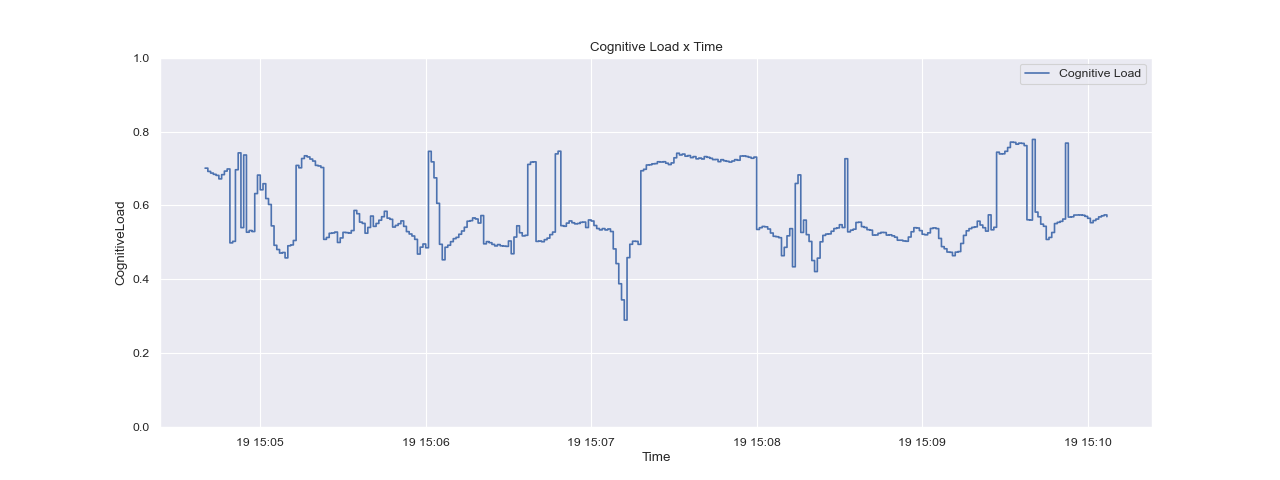

<function __main__.main(Graph)>

In [7]:
interact(main, Graph=["Charge Cognitive Graph", "Heart Rate Graph", "Pupil Dilation Graph", "Pupil Distance Graph", "Heart Rate x Cognitive Load Graph",
         "Pupil Distance x Cognitive Load Graph", "Pupil Dilation x Cognitive Load Graph", "Heart Rate x Pupil Distance x Cognitive Load Graph"])